In [1]:
!pip install pandas==1.5.3 numpy==1.24.2 seaborn==0.12.2 matplotlib==3.7.0 scikit-learn==1.2.1 keras==2.11.0 tensorflow==2.11.0 bokeh==3.0.3 tornado==6.1>> None

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
)

import keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks

from typing import Dict, Tuple

2023-02-25 09:56:28.043608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 09:56:28.175523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-25 09:56:28.175544: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-25 09:56:29.103256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
random_seed = 1


def set_global_determinism(random_seed=1):
    """
    Setting random seeds
    """
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    os.environ["TF_DETERMINISTIC_OPS"] = str(random_seed)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(random_seed)

    tf.keras.utils.set_random_seed(
        random_seed
    )  # sets seeds for base-python, numpy and tf
    tf.config.experimental.enable_op_determinism()


set_global_determinism(random_seed=random_seed)

Datasets used:
- 3 different heart disease (Healthcare)
- 1 credit fraud (Finance)

# Dataset #1: Heart Disease

In [4]:
url = "https://raw.githubusercontent.com/IvanReznikov/mdx-msc-data-science/main/datasets/heart_disease_uci.csv"
df = pd.read_csv(url)

In [5]:
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

In [6]:
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

## Algo #1.1: Random Forest

In [7]:
clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.30, random_state=random_seed
)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.30, random_state=random_seed
)

In [9]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

### Feature Importance

In [10]:
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)
sorted_idx = clf.feature_importances_.argsort()
feature_imp_df = pd.DataFrame(
    [X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx]]
).T.set_index(0)

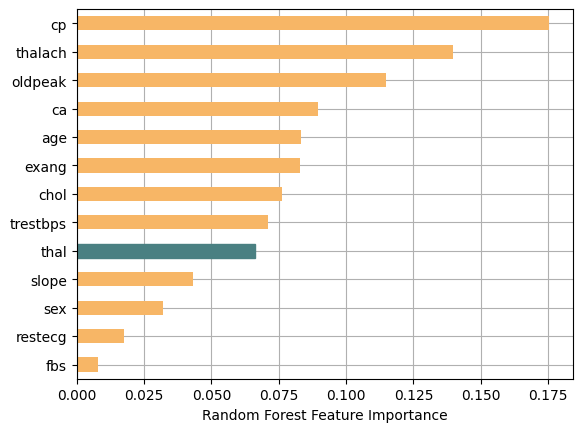

In [11]:
col = "thal"

ax = feature_imp_df.plot(
    kind="barh", color="#f7b666", legend=False, align="center", width=0.5
)
ax.set_xlabel("Random Forest Feature Importance")
ax.set_ylabel("")
ax.grid(True)
ax.set_axisbelow(True)

ax.patches[feature_imp_df.index.get_loc(col)].set_color("#4a8082")
plt.show()

In [12]:
y_pred = pd.Series(clf.predict(X_test), index=y_test.index)

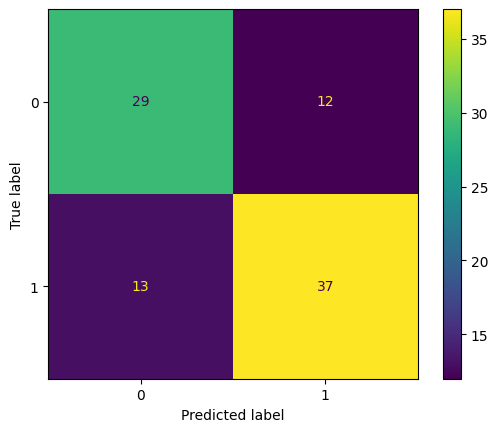

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
conf_matrix.plot()

In [14]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.7474747474747474, 0.74)

## Algo #1.2: Hybrid Post-Processing

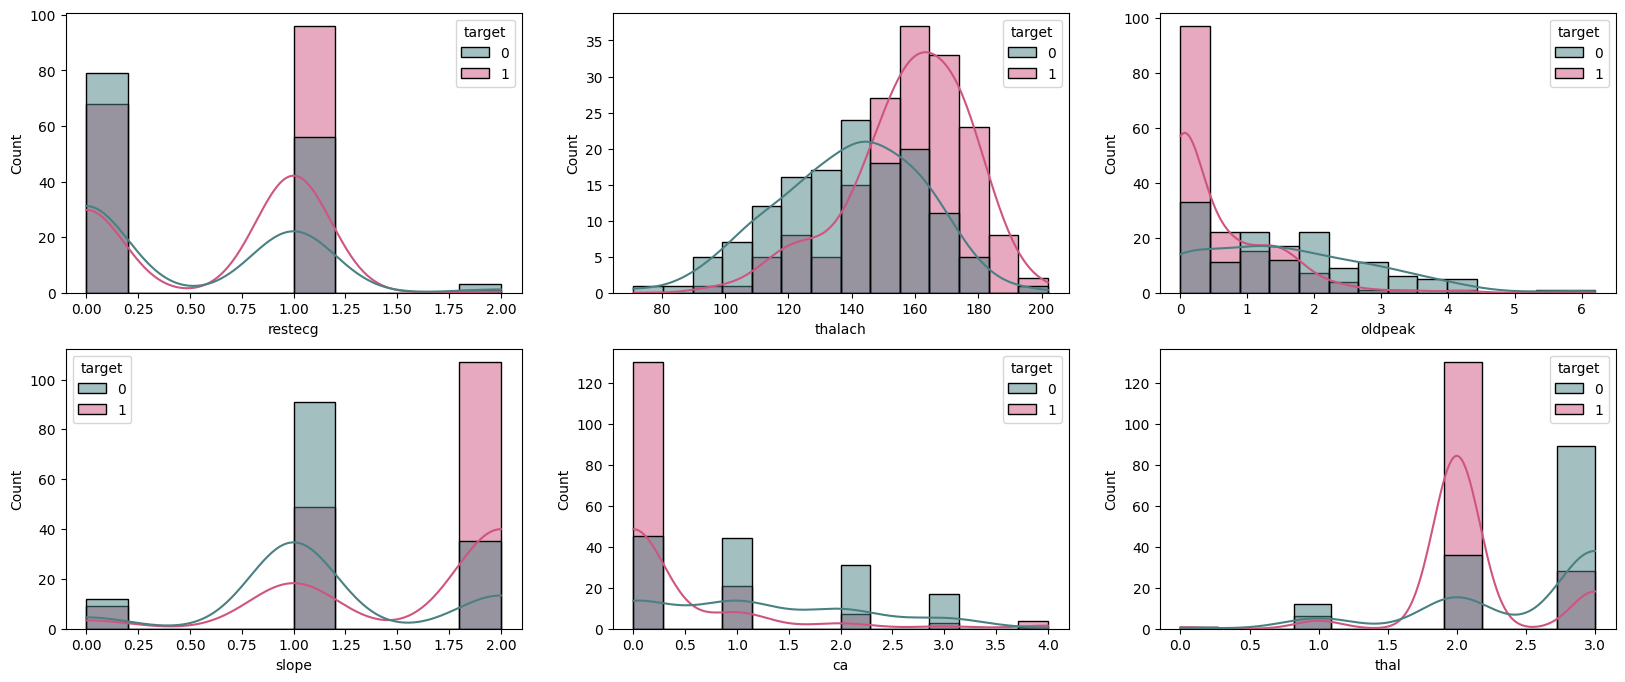

In [15]:
colors = ["#4a8082", "#ce5580"]
columns = ["restecg", "thalach", "oldpeak", "slope", "ca", "thal"]
ncols = 3
f, axes = plt.subplots(
    ncols=ncols,
    nrows=len(columns) // ncols + bool(len(columns) % ncols),
    figsize=(20, 8),
)

for idx, col in enumerate(columns):
    sns.histplot(
        df,
        x=col,
        hue="target",
        kde=True,
        fill=True,
        palette=colors,
        ax=axes[idx // ncols, idx % ncols],
    )

plt.show()

In [16]:
y_pred[X_test[X_test["thal"] == 2].index] = 1

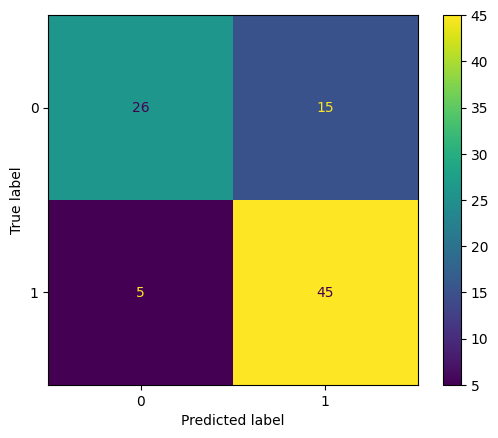

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
conf_matrix.plot()

In [18]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8181818181818182, 0.9)

## Algo #1.3: Hybrid Pre-Filtering

In [19]:
X_train = X_train[X_train["thal"] != 2]
y_train = y_train[X_train.index]

In [20]:
clf_mod = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [21]:
clf_mod.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [22]:
y_pred = pd.Series(clf_mod.predict(X_test), index=y_test.index)

In [23]:
y_pred[X_test[X_test["thal"] == 2].index] = 1

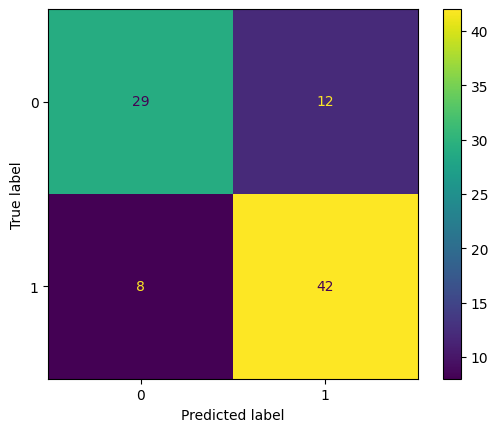

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=clf_mod.classes_)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf_mod.classes_
)
conf_matrix.plot()

In [25]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8076923076923077, 0.84)

## Algo #1.4: HybridEstimator - Production Version

In [26]:
from sklearn.base import BaseEstimator


class HybridEstimator(BaseEstimator):
    """Augments sklearn estimators with rule-based logic."""

    def __init__(
        self, base_model: BaseEstimator, rules: Dict, modify_data=False, **base_params
    ):
        """Initializes the HybridEstimator instance.
        Args:
            base_model: The underlying sklearn estimator.
              Must implement a fit and predict method.

            rules: The hard-coded rules in the format of a dictionary,
              with keys being the pandas dataframe column name, and the values
              being a tuple in the following form:
                  ({"==", "<", ">", "<=", ">=", "!="}, value, return value)
              Example:
                  {"some_column": [
                      ("==", 0, 0.0),
                  ],
                  "some_other_column": [
                      ("<", 1.0, 0.0),
                      (">=",100.0, 10.0)
                  ]}
            modify_data: Should the data be modified
            **base_params: Optional keyword arguments which will be passed on
            to the ``base_model``.

        Examples:
            >>> rf = RandomForestClassifier()
            >>> rules = {"some_column": [
                            ("==", 0, 0.0),
                        ],
                        "some_other_column": [
                            ("<", 1.0, 0.0),
                            (">=",100.0, 10.0)
                        ]}
            >>> ra_estimator = HybridEstimator(rf, rules)
        """

        self.rules = rules
        self.base_model = base_model
        self.modify_data = modify_data
        try:
            self.base_model.set_params(**base_params)
        except Exception as e:
            print(e)

    def __repr__(self):
        return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(
            self.base_model, self.rules
        )

    def __str__(self):
        return self.__str__

    def _get_base_model_data(
        self, X: pd.DataFrame, y: pd.Series
    ) -> Tuple[pd.DataFrame, pd.Series]:
        """Filters the trainig data for data points not affected by the rules."""

        X_train = X
        for category, rules in self.rules.items():
            if category not in X_train.columns.values:
                continue

            for rule, value, result in rules:
                if rule == "==":
                    X_train = X_train.loc[X_train[category] != value]

                elif rule == "!=":
                    X_train = X_train.loc[X_train[category] == value]

                elif rule == "<":
                    X_train = X_train.loc[X_train[category] >= value]

                elif rule == ">":
                    X_train = X_train.loc[X_train[category] <= value]

                elif rule == "<=":
                    X_train = X_train.loc[X_train[category] > value]

                elif rule == ">=":
                    X_train = X_train.loc[X_train[category] < value]

                else:
                    print(f"Invalid rule detected: {rule}, {value}")

        y_train = y[X_train.index]
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)
        return X_train, y_train

    def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
        """Fits the estimator to the data.

        Args:
            X: The training feature data.
            y: The training label data.
            **kwargs: Optional keyword arguments passed to the underlying
            estimator's fit function.

        """
        if self.modify_data:
            X_train, y_train = self._get_base_model_data(X, y)
        else:
            X_train, y_train = X, y
        self.base_model.fit(X_train, y_train, **kwargs)

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Gets predictions for the provided feature data.
        The predicitons are evaluated using the provided rules wherever possible
        otherwise the underlying estimator is used.

        Args:
            X: The feature data to evaluate predictions for.

        Returns:
            np.array: Evaluated predictions.
        """

        p_X = X.copy()
        p_X["prediction"] = np.nan

        for category, rules in self.rules.items():
            if category not in p_X.columns.values:
                continue

            for rule, value, result in rules:
                if rule == "==":
                    p_X.loc[p_X[category] == value, "prediction"] = result

                elif rule == "!=":
                    p_X.loc[p_X[category] != value, "prediction"] = result

                elif rule == "<":
                    p_X.loc[p_X[category] < value, "prediction"] = result

                elif rule == ">":
                    p_X.loc[p_X[category] > value, "prediction"] = result

                elif rule == "<=":
                    p_X.loc[p_X[category] <= value, "prediction"] = result

                elif rule == ">=":
                    p_X.loc[p_X[category] >= value, "prediction"] = result

                else:
                    print("Invalid rule detected: {}".format(rule))

        if not p_X["prediction"].isna().empty:
            base_X = p_X.loc[p_X["prediction"].isna()].copy()
            base_X.drop("prediction", axis=1, inplace=True)
            p_X.loc[p_X["prediction"].isna(), "prediction"] = self.base_model.predict(
                base_X
            )

        return p_X["prediction"].values

    def get_params(self, deep: bool = True) -> Dict:
        """Return the model's and base model's parameters.
        Args:
            deep: Whether to recursively return the base model's parameters.
        Returns
            Dict: The model's parameters.
        """

        params = {
            "base_model": self.base_model,
            "outcome_range": self.outcome_range,
            "rules": self.rules,
        }

        params.update(self.base_model.get_params(deep=deep))
        return params

    def set_params(self, **params):
        """Sets parameters for the model and base model.
        Args:
            **params: Optional keyword arguments.
        """

        parameters = params
        param_keys = parameters.keys()

        if "base_model" in param_keys:
            value = parameters.pop("base_model")
            self.base_model = value

        if "rules" in param_keys:
            value = parameters.pop("rules")
            self.rules = value

        self.base_model.set_params(**parameters)

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
# {col: [({"==", "<", ">", "<=", ">=", "!="}, value, return value)]}
rules = {
    "thal": [
        ("==", 2, 1),
    ]
}
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.30, random_state=random_seed
)

In [28]:
hybrid_model = HybridEstimator(rf, rules)
hybrid_model.fit(X_train, y_train)
y_pred = hybrid_model.predict(X_test)

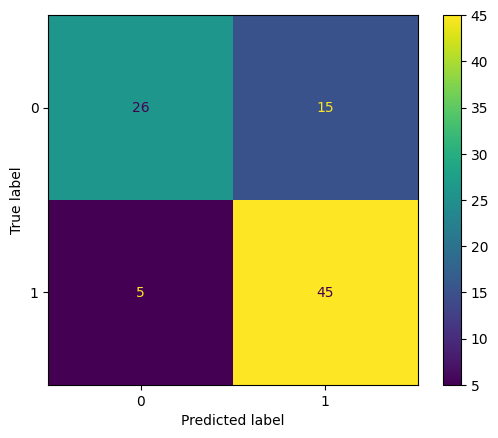

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
conf_matrix.plot()

In [30]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8181818181818182, 0.9)

In [31]:
hybrid_model = HybridEstimator(rf, rules, modify_data=True)
hybrid_model.fit(X_train, y_train)
y_pred = hybrid_model.predict(X_test)

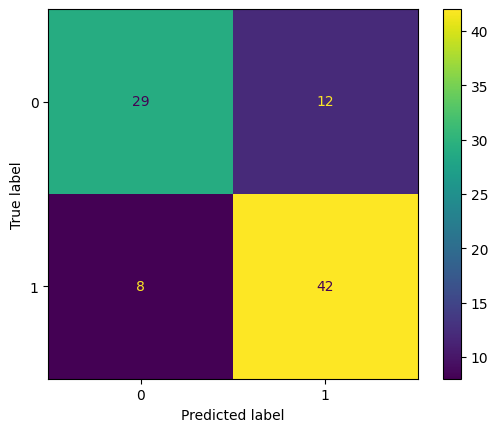

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
conf_matrix.plot()

In [33]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8076923076923077, 0.84)

# Dataset #2: Heart Failure

In [34]:
url = "https://raw.githubusercontent.com/IvanReznikov/mdx-msc-data-science/main/datasets/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(url)

In [35]:
df.drop(["time"], axis=1, inplace=True)

In [36]:
df["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [37]:
df

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                      1  265000.00               1.9           130    1   
1                      0  263358.03               1.1           136    1   
2                      0  162000.00               1.3           129    1   
3                      0  210000.00               1.9           137    1   
4                      0  327000.00               2.7           116    0   
..                   ...        ...               ...           ...  ...   
294                    1  155000.00               1.1           143    1   
295                    0  270000.00               1.2           139    0   
296                    0  742000.00               0.8           138    0   
297                    0  140000.00               1.4           140    1   
298                    0  395000.00               1.6           136    1   

     smoking  DEATH_EVENT  
0          0            1  
1          0            1  
2          1            1  
3          0            1  
4          0            1  
..       ...          ...  
294        1            0  
295        0            0  
296        0            0  
297        1            0  
298        1            0  

[299 rows x 12 columns]

## Algo #2.1. Random Forest

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.30, random_state=random_seed
)

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)

In [40]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [41]:
feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)
sorted_idx = rf.feature_importances_.argsort()
feature_imp_df = pd.DataFrame(
    [X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx]]
).T.set_index(0)

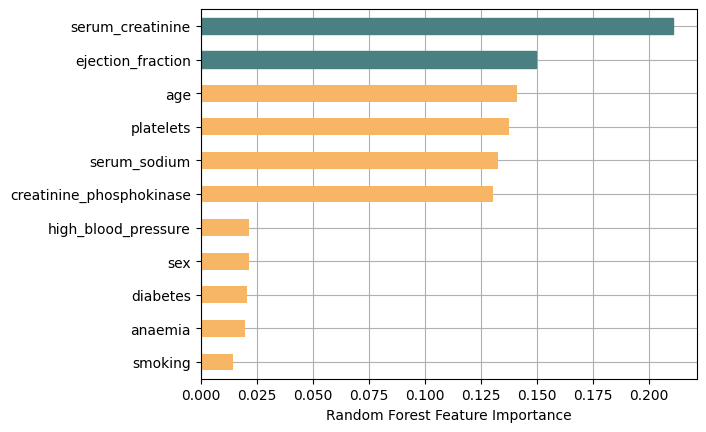

In [42]:
ax = feature_imp_df.plot(
    kind="barh", color="#f7b666", legend=False, align="center", width=0.5
)
ax.set_xlabel("Random Forest Feature Importance")
ax.set_ylabel("")
ax.grid(True)
ax.set_axisbelow(True)

ax.patches[-1].set_color("#4a8082")
ax.patches[-2].set_color("#4a8082")
plt.show()

In [43]:
y_pred = pd.Series(rf.predict(X_test), index=y_test.index)

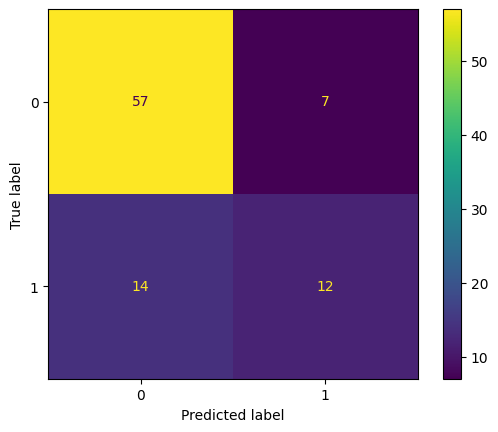

In [44]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
conf_matrix.plot()

In [45]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.5333333333333333, 0.46153846153846156)

## Algo #2.2. Hybrid System

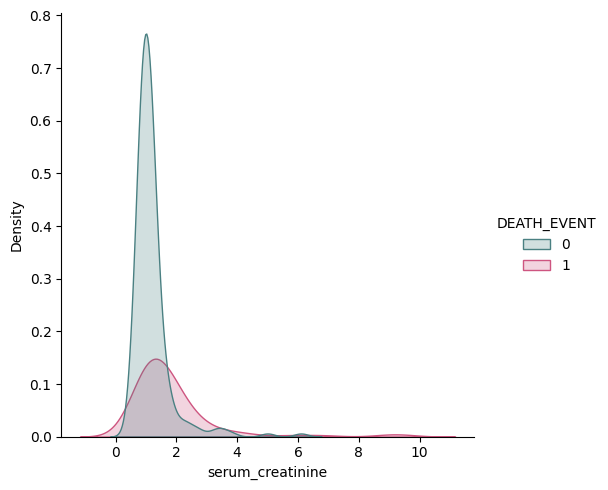

In [46]:
# ejection_fraction, serum_creatinine
sns.displot(
    df,
    x="serum_creatinine",
    hue="DEATH_EVENT",
    kind="kde",
    fill=True,
    palette=["#4a8082", "#ce5580"],
)

In [47]:
rules = {"ejection_fraction": [("<=", 20, 1)], "serum_creatinine": [(">=", 2, 1)]}

In [48]:
hybrid_model = HybridEstimator(rf, rules)
hybrid_model.fit(X_train, y_train)
y_pred = hybrid_model.predict(X_test)

In [49]:
y_pred = pd.Series(rf.predict(X_test), index=y_test.index)

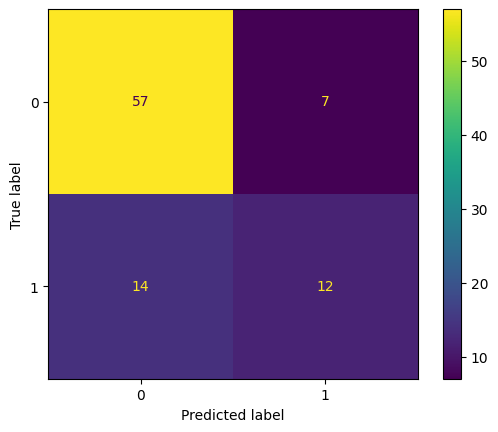

In [50]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
conf_matrix.plot()

In [51]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.5333333333333333, 0.46153846153846156)

# Dataset #3: Cardio deaths

In [52]:
url = "https://raw.githubusercontent.com/IvanReznikov/mdx-msc-data-science/main/datasets/cardio_train.csv"
df = pd.read_csv(url, delimiter=";")
df.drop(["id"], axis=1, inplace=True)

In [53]:
df["cardio"].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [54]:
df

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0      18393       2     168    62.0    110     80            1     1      0   
1      20228       1     156    85.0    140     90            3     1      0   
2      18857       1     165    64.0    130     70            3     1      0   
3      17623       2     169    82.0    150    100            1     1      0   
4      17474       1     156    56.0    100     60            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
69995  19240       2     168    76.0    120     80            1     1      1   
69996  22601       1     158   126.0    140     90            2     2      0   
69997  19066       2     183   105.0    180     90            3     1      0   
69998  22431       1     163    72.0    135     80            1     2      0   
69999  20540       1     170    72.0    120     80            2     1      0   

       alco  active  cardio  
0         0       1       0  
1         0       1       1  
2         0       0       1  
3         0       1       1  
4         0       0       0  
...     ...     ...     ...  
69995     0       1       0  
69996     0       1       1  
69997     1       0       1  
69998     0       0       1  
69999     0       1       0  

[70000 rows x 12 columns]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.25, random_state=random_seed
)

## Algo #3.1. Neural Network

In [56]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)


def set_nn_model():
    # Initialising the NN
    model = Sequential()

    # layers
    model.add(
        Dense(
            units=16,
            kernel_initializer="uniform",
            activation="relu",
            input_dim=X_train.shape[1],
        )
    )
    model.add(Dense(units=8, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(units=8, kernel_initializer="uniform", activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(units=1, kernel_initializer="uniform", activation="sigmoid"))
    return model


model = set_nn_model()

2023-02-25 09:56:34.885898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 09:56:34.885932: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 09:56:34.885956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-ThinkPad-T590): /proc/driver/nvidia/version does not exist
2023-02-25 09:56:34.886283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 409
Trainable params: 409
Non-trainable pa

In [58]:
def keras_f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [59]:
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras_f1_score]
)

In [60]:
# Train the ANN
history = model.fit(
    X_train,
    y_train,
    batch_size=25,
    epochs=80,
    callbacks=[early_stopping],
    validation_split=0.2,
)

Epoch 1/80
1680/1680 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5028 - keras_f1_score: 0.0590 - val_loss: 0.6932 - val_accuracy: 0.4994 - val_keras_f1_score: 3.1746e-04
Epoch 2/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.4992 - keras_f1_score: 0.1221 - val_loss: 0.6935 - val_accuracy: 0.4997 - val_keras_f1_score: 0.0017
Epoch 3/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5043 - keras_f1_score: 0.0176 - val_loss: 0.6945 - val_accuracy: 0.4996 - val_keras_f1_score: 0.0012
Epoch 4/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5034 - keras_f1_score: 0.0068 - val_loss: 0.6938 - val_accuracy: 0.4994 - val_keras_f1_score: 3.1746e-04
Epoch 5/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5020 - keras_f1_score: 0.2021 - val_loss: 0.6939 - val_accuracy: 0.4994 - val_keras_f1_score: 3.1746e-0

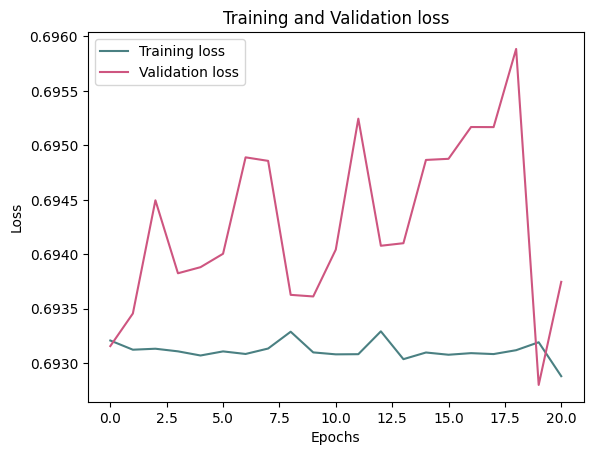

In [61]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ["loss"]], "#4a8082", label="Training loss")
plt.plot(history_df.loc[:, ["val_loss"]], "#ce5580", label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

plt.show()

In [62]:
model.predict(X_test).flatten()

547/547 [==============================] - 0s 683us/step


array([0.49841532, 0.49841532, 0.49841532, ..., 0.49841532, 0.49841532,
       0.49841532], dtype=float32)

In [63]:
y_pred = pd.Series(model.predict(X_test).flatten(), index=y_test.index)
y_pred = (y_pred > 0.5) * 1  # convert probabilities to binary output

547/547 [==============================] - 0s 803us/step


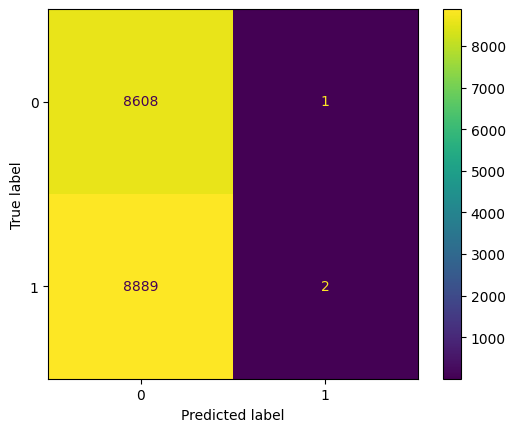

In [64]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_matrix.plot()

In [65]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.00044974139869575, 0.00022494657518839275)

## Algo 2.2. Hybrid System

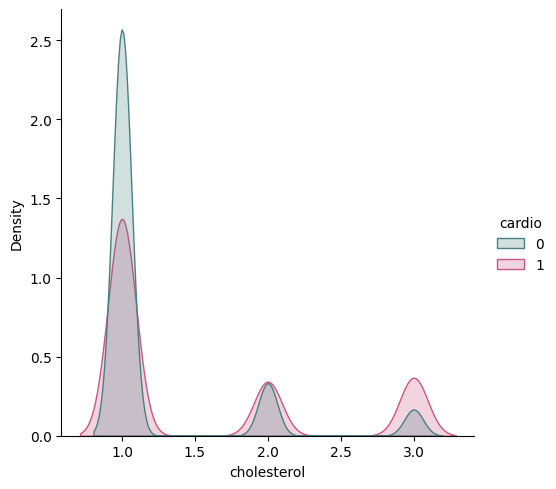

In [66]:
sns.displot(
    df,
    x="cholesterol",
    hue="cardio",
    kind="kde",
    fill=True,
    palette=["#4a8082", "#ce5580"],
)

In [67]:
rules = {"age": [(">=", 22000, 1)], "cholesterol": [("==", 3, 1)]}

In [68]:
model = set_nn_model()
model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", keras_f1_score]
)

hybrid_model = HybridEstimator(model, rules)
hybrid_model.fit(
    X_train,
    y_train,
    batch_size=25,
    epochs=80,
    callbacks=[early_stopping],
    validation_split=0.2,
)
y_pred = pd.Series(hybrid_model.predict(X_test).flatten(), index=y_test.index)
y_pred = (y_pred > 0.5) * 1  # convert probabilities to binary output

'Sequential' object has no attribute 'set_params'
Epoch 1/80
1680/1680 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5023 - keras_f1_score: 0.0778 - val_loss: 0.6930 - val_accuracy: 0.5090 - val_keras_f1_score: 0.0424
Epoch 2/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6931 - accuracy: 0.5003 - keras_f1_score: 0.0550 - val_loss: 0.6933 - val_accuracy: 0.4994 - val_keras_f1_score: 0.0000e+00
Epoch 3/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6930 - accuracy: 0.5103 - keras_f1_score: 0.1673 - val_loss: 0.6927 - val_accuracy: 0.4997 - val_keras_f1_score: 0.0022
Epoch 4/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6925 - accuracy: 0.5146 - keras_f1_score: 0.2658 - val_loss: 0.6892 - val_accuracy: 0.5193 - val_keras_f1_score: 0.0882
Epoch 5/80
1680/1680 [==============================] - 2s 1ms/step - loss: 0.6923 - accuracy: 0.5165 - keras_f1_score: 0.1382 - val_loss: 0.6937 - val_ac

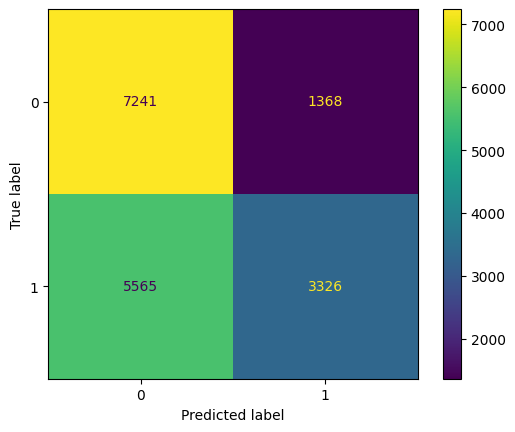

In [69]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_matrix.plot()

In [70]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.48965771071034236, 0.37408615453829713)

# Dataset #4. Credit Fraud

In [71]:
!pip install human-learn >> None

In [72]:
url = "https://raw.githubusercontent.com/IvanReznikov/mdx-msc-data-science/main/datasets/credit_card_fraud.csv"
df = pd.read_csv(url, index_col=0)

In [73]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [74]:
df

V1         V2        V3        V6        V9       V12  \
0       -1.359807  -0.072781  2.536347  0.462388  0.363787 -0.617801   
1        1.191857   0.266151  0.166480 -0.082361 -0.255425  1.065235   
2       -1.358354  -1.340163  1.773209  1.800499 -1.514654  0.066084   
3       -0.966272  -0.185226  1.792993  1.247203 -1.387024  0.178228   
4       -1.158233   0.877737  1.548718  0.095921  0.817739  0.538196   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.606837  1.914428  2.711941   
284803  -0.732789  -0.055080  2.035030  1.058415  0.584800  0.915802   
284804   1.919565  -0.301254 -3.249640  3.031260  0.432454  0.063119   
284805  -0.240440   0.530483  0.702510  0.623708  0.392087 -0.962886   
284806  -0.533413  -0.189733  0.703337 -0.649617  0.486180 -0.031513   

             V17  Class  
0       0.207971      0  
1      -0.114805      0  
2       1.109969      0  
3      -0.684093      0  
4      -0.237033      0  
...          ...    ...  
284802  1.991691      0  
284803 -0.025693      0  
284804  0.313502      0  
284805  0.509928      0  
284806 -0.660377      0  

[284807 rows x 8 columns]

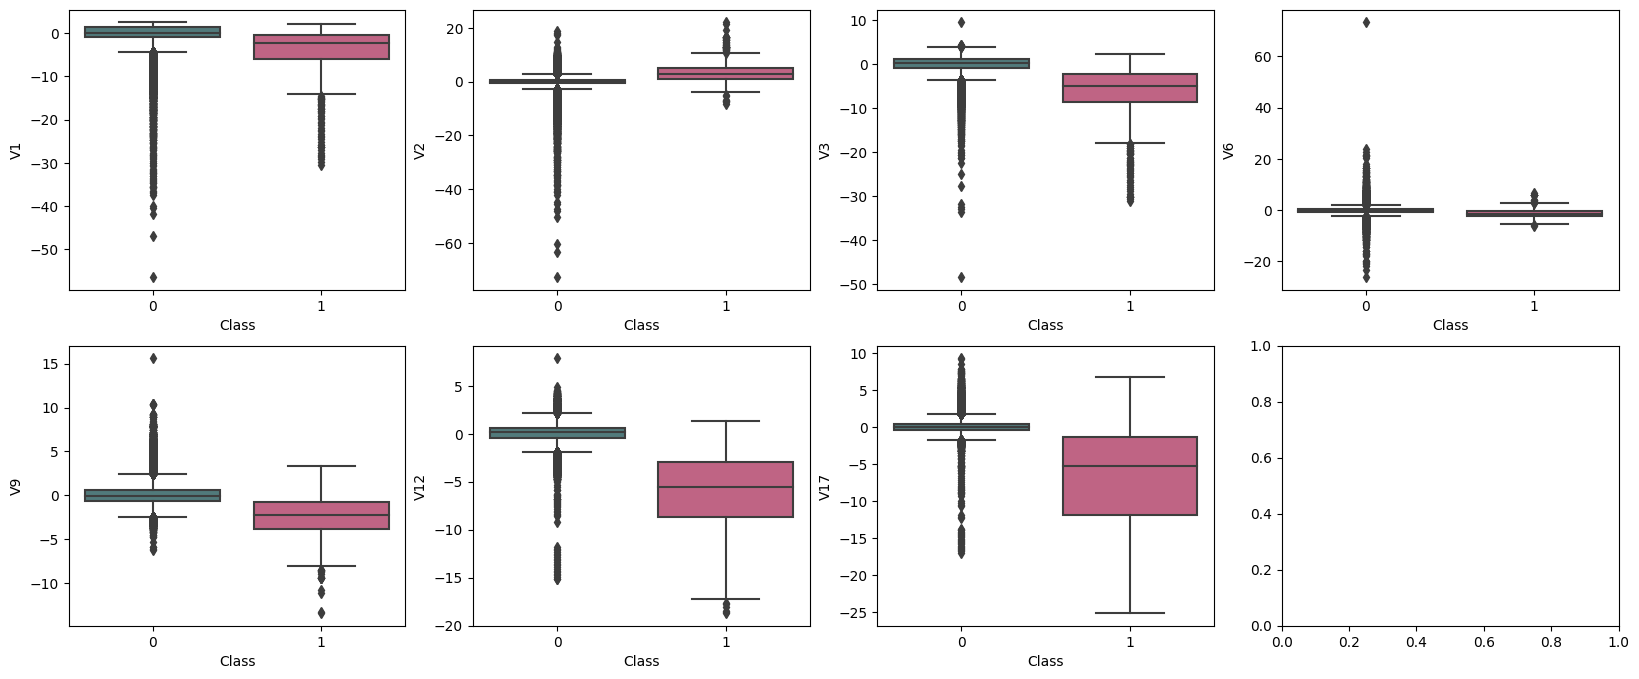

In [75]:
colors = ["#4a8082", "#ce5580"]
columns = ["V1", "V2", "V3", "V6", "V9", "V12", "V17"]
ncols = 4
f, axes = plt.subplots(
    ncols=ncols,
    nrows=len(columns) // ncols + bool(len(columns) % ncols),
    figsize=(20, 8),
)

for idx, col in enumerate(columns):
    sns.boxplot(
        x="Class", y=col, data=df, palette=colors, ax=axes[idx // ncols, idx % ncols]
    )

plt.show()

In [76]:
df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Algo #4.1. Human-learn, Single Feature

In [77]:
from hulearn.experimental.interactive import InteractiveCharts

charts = InteractiveCharts(df, labels="Class")
charts.add_chart(x="V12", y="V17")

Loading BokehJS ...

In case if the code above won't work, here is the gif file how it should

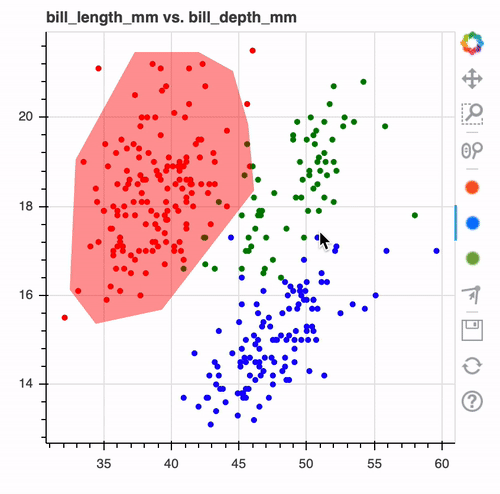

In [78]:
from hulearn.classification import FunctionClassifier
from sklearn.neighbors import KNeighborsClassifier


def create_rule_ge(data: pd.DataFrame, col: str, threshold: float = 100):
    return np.array(data[col] >= threshold).astype(int)


def create_rule_le(data: pd.DataFrame, col: str, threshold: float = 100):
    return np.array(data[col] <= threshold).astype(int)


mod = FunctionClassifier(create_rule_le, col="V12", threshold=-1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=random_seed
)

In [80]:
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

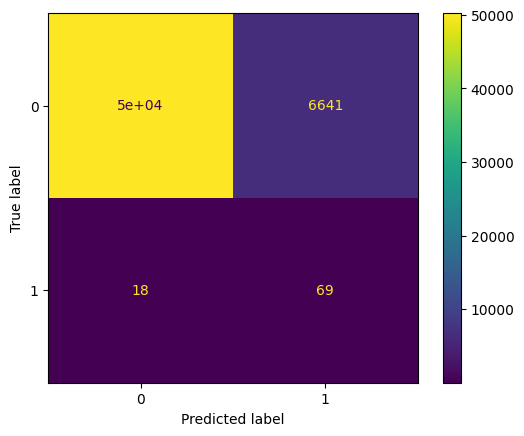

In [81]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_matrix.plot()

In [82]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.020303074885979107, 0.7931034482758621)

In [83]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(mod, cv=3, param_grid={"threshold": np.linspace(-5, 0, 100)})
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=FunctionClassifier(col='V12',
                                          func=<function create_rule_le at 0x7f187e30b1c0>,
                                          threshold=-1),
             param_grid={'threshold': array([-5.        , -4.94949495, -4.8989899 , -4.84848485, -4.7979798 ,
       -4.74747475, -4.6969697 , -4.64646465, -4.5959596 , -4.54545455,
       -4.49494949, -4.44444444, -4.39393939, -4.34343434, -4.29292929,
       -4.24242424, -4.19191919, -4.1414141...
       -1.46464646, -1.41414141, -1.36363636, -1.31313131, -1.26262626,
       -1.21212121, -1.16161616, -1.11111111, -1.06060606, -1.01010101,
       -0.95959596, -0.90909091, -0.85858586, -0.80808081, -0.75757576,
       -0.70707071, -0.65656566, -0.60606061, -0.55555556, -0.50505051,
       -0.45454545, -0.4040404 , -0.35353535, -0.3030303 , -0.25252525,
       -0.2020202 , -0.15151515, -0.1010101 , -0.05050505,  0.        ])})

In [84]:
best_threshold = grid.best_params_["threshold"]
best_threshold

-4.595959595959596

## Algo #4.2. Human-learn, Multiple Features

In [85]:
from hulearn.classification import FunctionClassifier

rules = {
    "V3": ("<=", -2),
    "V12": ("<=", -3),
    "V17": ("<=", -2),
}


def create_rules(data: pd.DataFrame, rules):
    filtered_data = data.copy()
    for col in rules:
        filtered_data[col] = eval(f"filtered_data[col] {rules[col][0]} {rules[col][1]}")
    result = np.array(filtered_data[list(rules.keys())].min(axis=1)).astype(int)
    return result


hybrid_classifier = FunctionClassifier(create_rules, rules=rules)

In [86]:
hybrid_classifier

FunctionClassifier(func=<function create_rules at 0x7f187de4a560>,
                   rules={'V12': ('<=', -3), 'V17': ('<=', -2),
                          'V3': ('<=', -2)})

In [87]:
hybrid_classifier.fit(X_train, y_train)
y_pred = hybrid_classifier.predict(X_test)

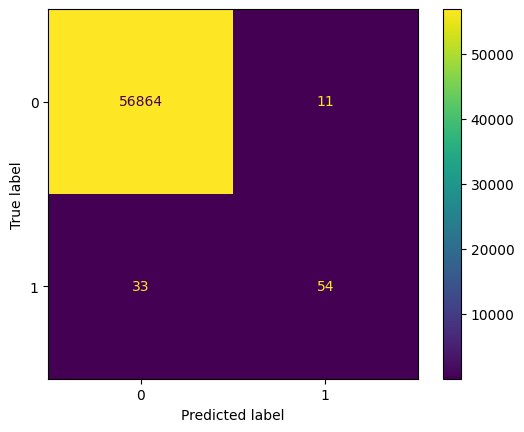

In [88]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_matrix.plot()

In [89]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.7105263157894737, 0.6206896551724138)

In [ ]:
from hulearn.experimental.interactive import parallel_coordinates

parallel_coordinates(df, label="Class", height=200)

In [91]:
"""
from hulearn.experimental.interactive import parallel_coordinates
parallel_coordinates(df, label="Class", height=200)
"""

'\nfrom hulearn.experimental.interactive import parallel_coordinates\nparallel_coordinates(df, label="Class", height=200)\n'

# Algo #4.3. KNeighborsClassifier

In [92]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

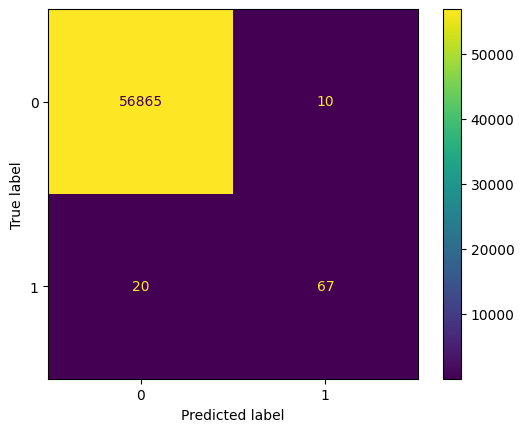

In [93]:
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
conf_matrix.plot()

In [94]:
f1_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.8170731707317073, 0.7701149425287356)

ERROR:bokeh.server.views.ws:Refusing websocket connection from Origin 'http://127.0.0.1:8888';                       use --allow-websocket-origin=127.0.0.1:8888 or set BOKEH_ALLOW_WS_ORIGIN=127.0.0.1:8888 to permit this; currently we allow origins {'localhost:8888'}
